In [1]:
import kwant
import numpy as np

import meanfi
from meanfi.kwant_helper import utils
from meanfi.tb.transforms import tb_to_kfunc

s0 = np.identity(2)
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.diag([1, -1])

# Create graphene lattice
graphene = kwant.lattice.general(
    [(1, 0), (1 / 2, np.sqrt(3) / 2)], [(0, 0), (0, 1 / np.sqrt(3))], norbs=2
)
a, b = graphene.sublattices

# Create bulk system
bulk_graphene = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
# Set onsite energy to zero
bulk_graphene[a.shape((lambda pos: True), (0, 0))] = 0 * s0
bulk_graphene[b.shape((lambda pos: True), (0, 0))] = 0 * s0
# Add hoppings between sublattices
bulk_graphene[graphene.neighbors(1)] = s0

def onsite_int(site, U):
    return U * sx

def nn_int(site1, site2, V):
    return V * np.ones((2, 2))

builder_int = utils.build_interacting_syst(
    builder=bulk_graphene,
    lattice=graphene,
    func_onsite=onsite_int,
    func_hop=nn_int,
    max_neighbor=1
)
params = dict(U=2.5, V=0)
h_int_temp = utils.builder_to_tb(builder_int, params)
h_int = {(0,0) : h_int_temp[(0,0)]} # only keep onsite for efficiency
h_0 = utils.builder_to_tb(bulk_graphene)

In [4]:
# inputs here
# you might need to restart this many times to succeed, because once occupation diff is too large, the solver will fail
# will need to look into constrained optimization to fix this

filling = 2+1e-4
model = meanfi.Model(h_0, h_int, filling=filling, atol=1e-3, beta=1e2)

int_keys = frozenset(h_int)
ndof = len(list(h_0.values())[0])
mf_guess = meanfi.guess_tb(int_keys, ndof)
mu_guess = 0
optimizer_kwargs={'M': 10, 'line_search' : 'wolfe', 'maxiter': 200}
mf_sol = meanfi.solver(model, mf_guess, mu_guess, optimizer_kwargs=optimizer_kwargs, debug=True)
h_full = meanfi.add_tb(h_0, mf_sol)
hfunc = tb_to_kfunc(h_full)

--------------------
Occupation difference cost: -0.7513483855042602
Chemical Potential: 0.0
Cost function: 1.3667846591481485
--------------------
--------------------
Occupation difference cost: -0.7513483928508662
Chemical Potential: -1.4253464533869242e-08
Cost function: 1.3667846441247438
--------------------
--------------------
Occupation difference cost: -0.9495382988752883
Chemical Potential: -0.475115484462308
Cost function: 0.7977022379309808
--------------------
--------------------
Occupation difference cost: -0.9495382902017713
Chemical Potential: -0.4751154706514573
Cost function: 0.7977022376515486
--------------------
--------------------
Occupation difference cost: -0.616582106612716
Chemical Potential: -0.02525801590773602
Cost function: 0.7187844294665579
--------------------
--------------------
Occupation difference cost: -0.6165820882225215
Chemical Potential: -0.02525799759831071
Cost function: 0.7187703179533557
--------------------
--------------------
Occupat

In [5]:
# Number of k-points
Nk = 200
kx_vals = np.linspace(-np.pi, np.pi, Nk)
energies = []

for i, kx in enumerate(kx_vals):
    H = hfunc(np.array([kx, np.pi/1.5]).reshape(1, -1))
    vals, vecs = np.linalg.eigh(H)
    
    energies.append(vals)
energies = np.array(energies)

/tmp/ipykernel_114754/2155375988.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


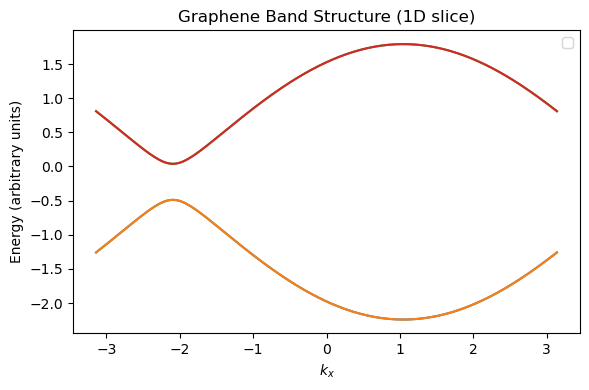

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

plt.plot(kx_vals, energies)

plt.xlabel(r"$k_x$")
plt.ylabel("Energy (arbitrary units)")
plt.title("Graphene Band Structure (1D slice)")
plt.legend()
plt.tight_layout()
plt.show()